## r0 to r1 calibrator


In [1]:

%load_ext autoreload
%autoreload 2

from ctapipe.io import event_source
import sys
 
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import sys
from scipy.stats import norm
from traitlets.config.loader import Config 
from ctapipe import utils
from ctapipe_io_lst import LSTEventSource


# ctapipe modules
from ctapipe.visualization import CameraDisplay
#from ctapipe.plotting.camera import CameraPlotter
from ctapipe.image.extractor import *
from ctapipe.containers import PedestalContainer
from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader
from lstchain.calib.camera.r0 import LSTR0Corrections
from lstchain.calib.camera.calibrator import LSTCameraCalibrator


tel_id=1 


/Users/rlopezcoto/opt/anaconda3/envs/lst/lib/python3.7/site-packages/ctapipe/tools/stage1.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
r0_r1_calibrator = LSTR0Corrections(
    pedestal_path="../data/drs4_pedestal.Run1623.0000.fits",
    r1_sample_start=2,r1_sample_end=38, tel_id=tel_id)

# r1 to dl1 calibrator
inp="../data/calibration.Run1625.0000.hdf5"
time_calib = "../data/time_calibration.Run1625.0000.hdf5"
charge_config = Config({
    "LocalPeakWindowSum": {
        "window_shift": 4,
        "window_width": 8 
    }
})


reader = LSTEventSource(input_url="../data/LST-1.1.Run01627.0001.fits.fz",
                        max_events=1000)
subarray = reader.subarray

r1_dl1_calibrator = LSTCameraCalibrator(calibration_path = inp,
                               time_calibration_path = time_calib,
                               gain_threshold = 3000,
                               image_extractor="LocalPeakWindowSum",
                               config=charge_config,
                               subarray = subarray
                                )

# shower events

print(f"\n Read {len(reader.multi_file)} total events  in files\n")
print(f"{reader.file_list} ")

EXTRACTOR <ctapipe.image.extractor.LocalPeakWindowSum object at 0x7fe0036f6ed0>

 Read 53000 total events  in files

['/Users/rlopezcoto/Desktop/2021_02_School/intro-iact-analysis/notebooks/data/LST-1.4.Run01627.0001.fits.fz', '/Users/rlopezcoto/Desktop/2021_02_School/intro-iact-analysis/notebooks/data/LST-1.2.Run01627.0001.fits.fz', '/Users/rlopezcoto/Desktop/2021_02_School/intro-iact-analysis/notebooks/data/LST-1.1.Run01627.0001.fits.fz', '/Users/rlopezcoto/Desktop/2021_02_School/intro-iact-analysis/notebooks/data/LST-1.3.Run01627.0001.fits.fz'] 


In [3]:
# function to plot charge and time

def plot_charge_time():
    
    dim = event.dl1.tel[tel_id].image.ndim
    #dim = event.dl1.tel[tel_id].image.ndim
    if dim == 1:
        fig = plt.figure(figsize=(16, 8))
        pad = 120
        mask= np.where((event.lst.tel[tel_id].evt.pixel_status >> 2 & 1>0))
    else:
        fig = plt.figure(figsize=(16, 16))
        pad = 220
        mask =[]


    for chan in np.arange(dim):
        if dim == 1:
            image = event.dl1.tel[tel_id].image
        else:   
            image = event.dl1.tel[tel_id].image[chan]

        pad+=1
        ax = plt.subplot(pad)
        plt.tight_layout()
        disp = CameraDisplay(subarray.tels[tel_id].camera.geometry)
        disp.image = image  
        disp.cmap = plt.cm.coolwarm
        disp.set_limits_minmax(0,200)
        disp.axes.text(1.8, 0, f'charge (pe)', rotation=90)
        disp.add_colorbar()
        plt.tight_layout()
        print(f"charge : mean {image.mean()} +- {image.std()}")
        disp.highlight_pixels(mask,linewidth=2)

        pad+=1  
        if dim == 1:
            image = event.dl1.tel[tel_id].peak_time 
        else:   
            image = event.dl1.tel[tel_id].peak_time[chan]

        ax = plt.subplot(pad)  
        plt.tight_layout()
        disp = CameraDisplay(subarray.tels[tel_id].camera.geometry)
        disp.image = image 
        disp.highlight_pixels(mask,linewidth=2)
        disp.set_limits_minmax(-10,10)
        disp.cmap = plt.cm.coolwarm
        disp.axes.text(1.8, 0, f' time (ns)', rotation=90)
        disp.add_colorbar()
        plt.tight_layout()
        print(f"time: mean {image.mean()} +- {image.std()}")


EXTRACTOR <ctapipe.image.extractor.LocalPeakWindowSum object at 0x7fdffdf16090>
max pe 345.3169860839844
read event id: 53414, trigger 1
charge : mean 6.342785835266113 +- 21.85396957397461
time: mean 17.575120721461342 +- 9.710306208038393
charge : mean 7.355536460876465 +- 25.17167854309082
time: mean 13.968952050443534 +- 10.978312257170732


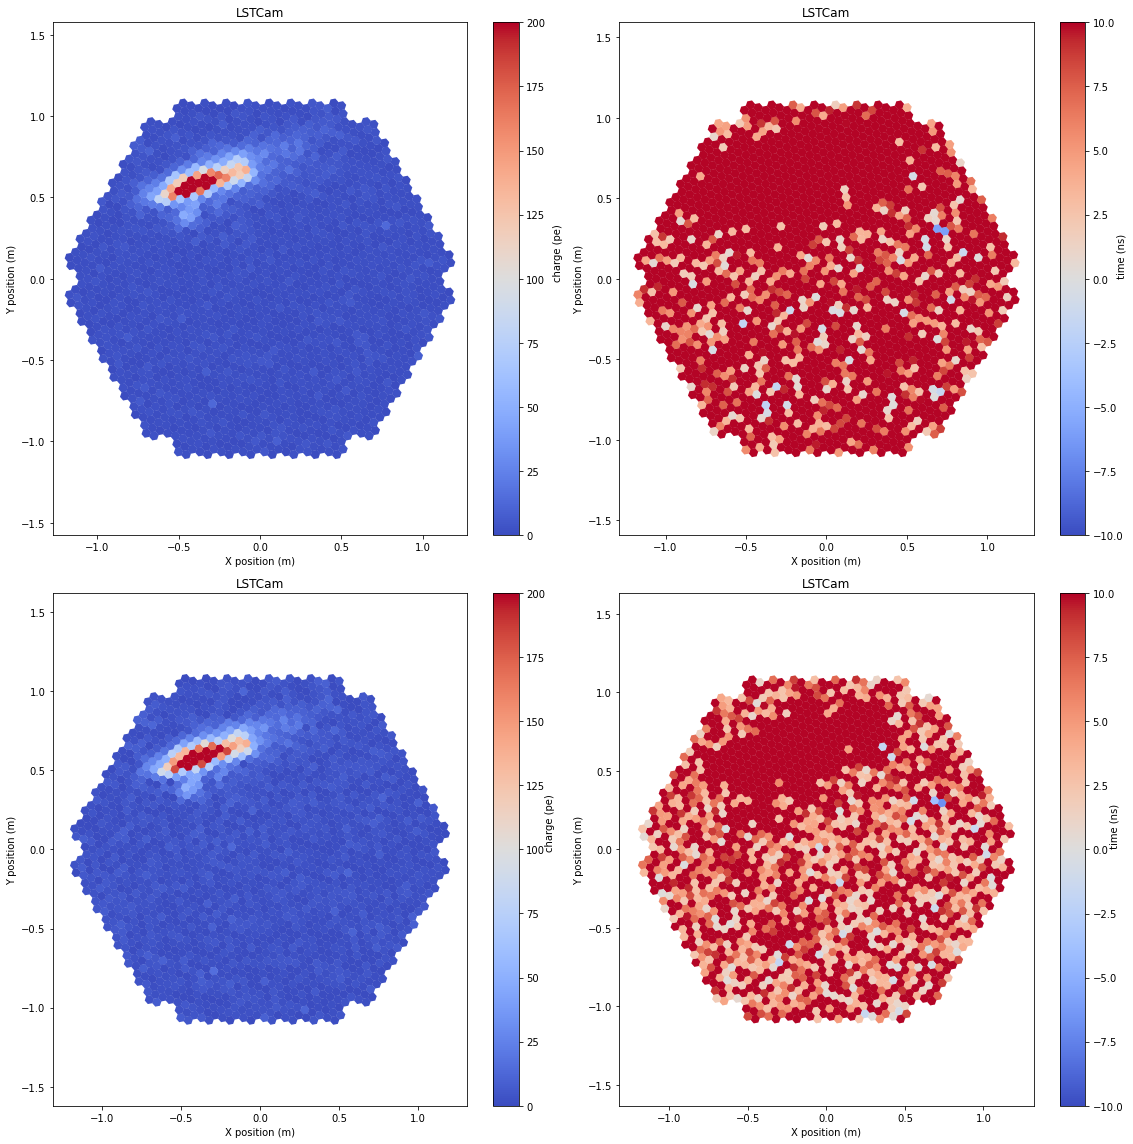

In [4]:
# loop on events
r1_dl1_calibrator = LSTCameraCalibrator(calibration_path = inp,
                               time_calibration_path = time_calib,
                               gain_threshold = None,
                               image_extractor="LocalPeakWindowSum",
                               config=charge_config,
                               subarray=subarray 
                                    )

for i, event in enumerate(reader):
    
    if event.index.event_id%500 == 0:
        print(event.index.event_id)
              
    # calibrate r0 --> r1        
    r0_r1_calibrator.calibrate(event)
   
    # if triggerd event
    if event.r0.tel[tel_id].trigger_type != 32:                   
        
        # calibrate r1 --> dl1
        r1_dl1_calibrator(event)
        image = event.dl1.tel[tel_id].image
        
        # select image with bright event and stop
        if np.max(image>200):             
            print(f"max pe {np.max(image)}")
            break
            
            
print(f"read event id: {event.index.event_id}, trigger {event.r0.tel[tel_id].trigger_type}")

# plot selected event
plot_charge_time()

## with gain selection

EXTRACTOR <ctapipe.image.extractor.LocalPeakWindowSum object at 0x7fdfe98d7f10>
53500
max pe 1160.31591796875
read event id: 53747, trigger 1
charge : mean 11.51282024383545 +- 62.88167953491211
time: mean 16.929901123046875 +- 9.739818572998047


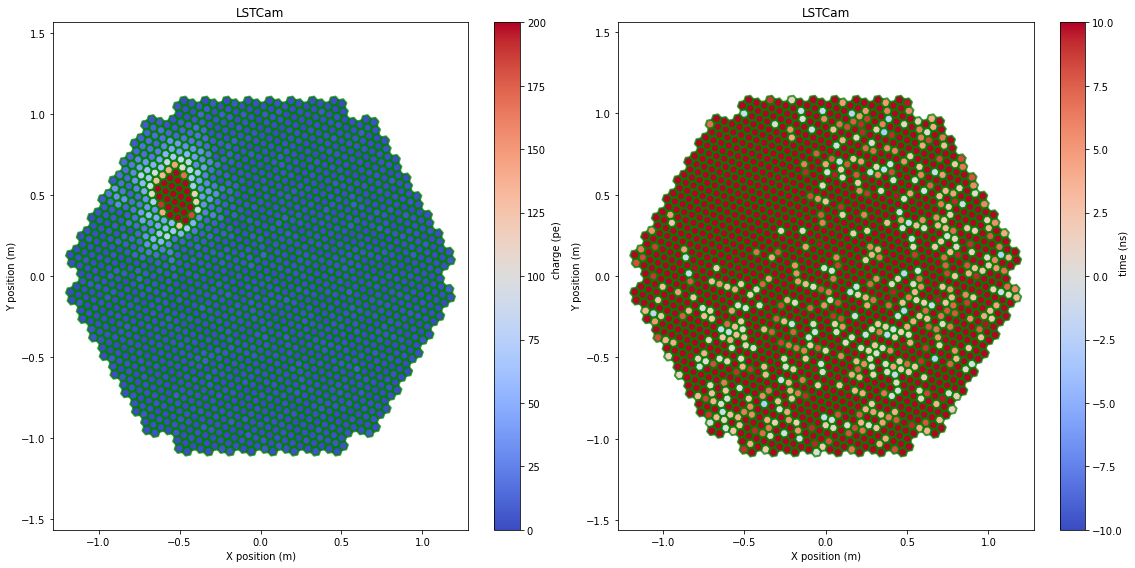

In [5]:
# loop on events
r1_dl1_calibrator = LSTCameraCalibrator(calibration_path = inp,
                               time_calibration_path = time_calib,
                               gain_threshold = 3000,
                               image_extractor="LocalPeakWindowSum",
                               config=charge_config,
                               subarray=subarray                                        
                                       )

for i, event in enumerate(reader):
    
    if event.index.event_id%500 == 0:
        print(event.index.event_id)
              
    # calibrate r0 --> r1        
    r0_r1_calibrator.calibrate(event)
   
    # if triggerd event
    if event.r0.tel[tel_id].trigger_type != 32:                   
        
        # calibrate r1 --> dl1
        r1_dl1_calibrator(event)
        image = event.dl1.tel[tel_id].image
        # bit 2 == LG 
        mask = event.lst.tel[tel_id].evt.pixel_status >> 2 & 1
        # select image with bright event and stop
        if(np.max(image>200) and np.max(mask)>0):             
            print(f"max pe {np.max(image)}")
            break
            
            
print(f"read event id: {event.index.event_id}, trigger {event.r0.tel[tel_id].trigger_type}")

# plot selected event
plot_charge_time()

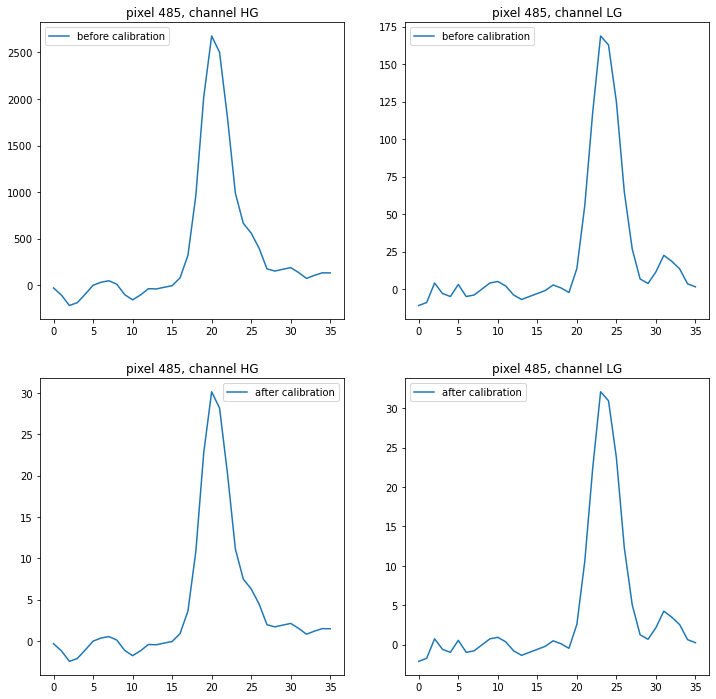

In [16]:
channel=['HG','LG']

a=np.where(event.dl1.tel[1].image>100)
pix=a[0][0]

fig = plt.figure(300,figsize=(12, 12))
label="after calibration"
label1="before calibration"
chan=0
plt.subplot(2, 2, 1)
plt.title(f"pixel {pix}, channel {channel[chan]}")
plt.plot(event.r1.tel[1].waveform[chan,pix], label=label1)
plt.legend()
plt.subplot(2, 2, 3)
plt.title(f"pixel {pix}, channel {channel[chan]}")
plt.plot(event.dl0.tel[1].waveform[chan,pix], label=label)   
plt.title(f"pixel {pix}, channel {channel[chan]}")
plt.legend()
chan=1
plt.subplot(2, 2, 2)
plt.title(f"pixel {pix}, channel {channel[chan]}")
plt.plot(event.r1.tel[1].waveform[chan,pix], label=label1)
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(event.dl0.tel[1].waveform[chan,pix], label=label)
plt.title(f"pixel {pix}, channel {channel[chan]}")
plt.legend()
